In [1]:
import torch
import torch.nn as nn
import torch.cuda as cuda
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Subset
from torch.utils.data import Dataset, random_split

In [2]:
import random
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

In [ ]:
# Normal case: load the entire dataset

# Data transformations
transform_train = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to 64x64
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to 64x64
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load GTSRB training set
trainset = torchvision.datasets.GTSRB(root='./data', split='train', download=True, transform=transform_train)

# Load MNIST
# trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)

# Define split proportions
train_size = 11000
val_size = 15640

# Get total number of samples
total_size = len(trainset)

print(total_size)

# Generate random indices for train and validation
indices = torch.randperm(total_size).tolist()
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size+val_size]

# Create custom subsets
train_subset = Subset(trainset, train_indices)
val_subset = Subset(trainset, val_indices)

# Create DataLoaders for each subset
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2)
externalloader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=True, num_workers=2)

# Load GTSRB test set
valset = torchvision.datasets.GTSRB(root='./data', split='test', download=True, transform=transform_test)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False, num_workers=2)

# Print dataset sizes
print(len(trainset)) 
print(len(valset))

26640
26640
12630


In [ ]:
from collections import Counter

def get_class_distribution(dataloader):
    # Create a Counter to store the labels and their frequencies
    label_counter = Counter()
    
    # Iterate over the dataloader
    for _, labels in dataloader:
        label_counter.update(labels.numpy())
    
    # Convert the Counter to a dictionary
    class_distribution = dict(label_counter)
    
    return class_distribution

# Example usage
class_distribution = get_class_distribution(trainloader)
class_distribution2 = get_class_distribution(externalloader)

num_classes = len(class_distribution)
print(f'Number of classes in the trainloader: {num_classes}')

for class_label, count in class_distribution.items():
    print(f'Class {class_label}: {count} samples')

num_classes = len(class_distribution2)
print(f'Number of classes in the externalloader: {num_classes}')

for class_label, count in class_distribution2.items():
    print(f'Class {class_label}: {count} samples')

KeyboardInterrupt: 

In [ ]:
modelclass = 'xception'
num_classesmodel = 43

In [ ]:
if modelclass == 'resnet':
    class Bottleneck(nn.Module):
        expansion = 4
        def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
            super(Bottleneck, self).__init__()
            
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
            self.batch_norm1 = nn.BatchNorm2d(out_channels)
            
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
            self.batch_norm2 = nn.BatchNorm2d(out_channels)
            
            self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
            self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
            
            self.i_downsample = i_downsample
            self.stride = stride
            self.relu = nn.ReLU()
            
        def forward(self, x):
            identity = x.clone()
            x = self.relu(self.batch_norm1(self.conv1(x)))
            
            x = self.relu(self.batch_norm2(self.conv2(x)))
            
            x = self.conv3(x)
            x = self.batch_norm3(x)
            
            #downsample if needed
            if self.i_downsample is not None:
                identity = self.i_downsample(identity)
            #add identity
            x+=identity
            x=self.relu(x)
            
            return x

    class Block(nn.Module):
        expansion = 1
        def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
            super(Block, self).__init__()
        

            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
            self.batch_norm1 = nn.BatchNorm2d(out_channels)
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
            self.batch_norm2 = nn.BatchNorm2d(out_channels)

            self.i_downsample = i_downsample
            self.stride = stride
            self.relu = nn.ReLU()

        def forward(self, x):
            identity = x.clone()

            x = self.relu(self.batch_norm2(self.conv1(x)))
            x = self.batch_norm2(self.conv2(x))

            if self.i_downsample is not None:
                identity = self.i_downsample(identity)
            print(x.shape)
            print(identity.shape)
            x += identity
            x = self.relu(x)
            return x


            
            
    class ResNetAdversial(nn.Module):
        def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
            super(ResNetAdversial, self).__init__()
            self.in_channels = 64
            
            self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
            self.batch_norm1 = nn.BatchNorm2d(64)
            self.relu = nn.ReLU()
            self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
            
            self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
            self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
            self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
            self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)
            
            self.avgpool = nn.AdaptiveAvgPool2d((1,1))
            self.fc = nn.Linear(512*ResBlock.expansion, num_classes)

            # CNN       
            self.conv6 = nn.Conv2d(1024, 2048, kernel_size=3, padding=1)
            self.conv66 = nn.Conv2d(2048, 2048, kernel_size=3, padding=1)
            self.conv666 = nn.Conv2d(2048, 4096, kernel_size=3, padding=1)
            self.conv7 = nn.Conv2d(512, 2048, kernel_size=3, padding=1)
            self.conv77 = nn.Conv2d(2048, 2048, kernel_size=3, padding=1)
            self.conv777 = nn.Conv2d(2048, 4096, kernel_size=3, padding=1)
            self.bn1 = nn.BatchNorm2d(2048)
            self.bn11 = nn.BatchNorm2d(2048)
            self.bn111 = nn.BatchNorm2d(4096)
            self.bn2 = nn.BatchNorm2d(2048)
            self.bn22 = nn.BatchNorm2d(2048)
            self.bn222 = nn.BatchNorm2d(4096)
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
            self.poollayer = nn.AdaptiveMaxPool2d(1)
            self.fc1 = nn.Linear(4096, 128)
            self.dropout = nn.Dropout(0.5)
            self.fc2 = nn.Linear(2048, 128)
            self.fc3 = nn.Linear(128, 1)
            self.relu = nn.ReLU()
            self.sigmoid = nn.Sigmoid()
            
        def forward(self, x):
            x = self.relu(self.batch_norm1(self.conv1(x)))
            x = self.max_pool(x)
            # Después de cada una de estas es lo que cogemos y por tanto es lo usamos para el adv model
            x1 = self.layer1(x) 
            x2 = self.layer2(x1)
            x3 = self.layer3(x2)
            x4 = self.layer4(x3)
            
            x5 = self.avgpool(x4)
            x5 = x5.reshape(x5.shape[0], -1)
            x5 = self.fc(x5)

            # CNN part
            xc1 = self.conv6(x3)
            xc1 = self.pool(xc1)
            xc1 = self.conv66(xc1)
            # xc1 = self.bn111(self.conv666(xc1))
            xc2 = self.conv7(x2)
            xc2 = self.pool(xc2)
            xc2 = self.conv77(xc2)
            # xc2 = self.bn222(self.conv777(xc2))
            # x2 = self.conv7(x2)
            xc1 = self.poollayer(xc1)
            xc2 = self.poollayer(xc2)
            x_concat = torch.cat((xc1, xc2), dim=1)
            xc = x_concat.view(x_concat.size(0), -1)
            xc = self.relu(self.fc1(xc))
            # xc = self.relu(self.fc2(xc))
            xc = self.sigmoid(self.fc3(xc))
            
            
            return x5, xc
            
        def _make_layer(self, ResBlock, blocks, planes, stride=1):
            ii_downsample = None
            layers = []
            
            if stride != 1 or self.in_channels != planes*ResBlock.expansion:
                ii_downsample = nn.Sequential(
                    nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                    nn.BatchNorm2d(planes*ResBlock.expansion)
                )
                
            layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
            self.in_channels = planes*ResBlock.expansion
            
            for i in range(blocks-1):
                layers.append(ResBlock(self.in_channels, planes))
                
            return nn.Sequential(*layers)

            
            
    def ResNet50(num_classes, channels=3):
        return ResNetAdversial(Bottleneck, [3,4,6,3], num_classes, channels)
        
    def ResNet101(num_classes, channels=3):
        return ResNetAdversial(Bottleneck, [3,4,23,3], num_classes, channels)

    def ResNet152(num_classes, channels=3):
        return ResNetAdversial(Bottleneck, [3,8,36,3], num_classes, channels)

In [ ]:
if modelclass == 'densenet':
    class Bottleneck(nn.Module):
        def __init__(self, in_channels, growth_rate):
            super().__init__()
            #"""In  our experiments, we let each 1×1 convolution
            #produce 4k feature-maps."""
            inner_channel = 4 * growth_rate

            #"""We find this design especially effective for DenseNet and
            #we refer to our network with such a bottleneck layer, i.e.,
            #to the BN-ReLU-Conv(1×1)-BN-ReLU-Conv(3×3) version of H ` ,
            #as DenseNet-B."""
            self.bottle_neck = nn.Sequential(
                nn.BatchNorm2d(in_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels, inner_channel, kernel_size=1, bias=False),
                nn.BatchNorm2d(inner_channel),
                nn.ReLU(inplace=True),
                nn.Conv2d(inner_channel, growth_rate, kernel_size=3, padding=1, bias=False)
            )

        def forward(self, x):
            return torch.cat([x, self.bottle_neck(x)], 1)

    #"""We refer to layers between blocks as transition
    #layers, which do convolution and pooling."""
    class Transition(nn.Module):
        def __init__(self, in_channels, out_channels):
            super().__init__()
            #"""The transition layers used in our experiments
            #consist of a batch normalization layer and an 1×1
            #convolutional layer followed by a 2×2 average pooling
            #layer""".
            self.down_sample = nn.Sequential(
                nn.BatchNorm2d(in_channels),
                nn.Conv2d(in_channels, out_channels, 1, bias=False),
                nn.AvgPool2d(2, stride=2)
            )

        def forward(self, x):
            return self.down_sample(x)

    #DesneNet-BC
    #B stands for bottleneck layer(BN-RELU-CONV(1x1)-BN-RELU-CONV(3x3))
    #C stands for compression factor(0<=theta<=1)
    class DenseNet(nn.Module):
        def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_class=100):
            super().__init__()
            self.growth_rate = growth_rate

            inner_channels = 2 * growth_rate
            self.conv1 = nn.Conv2d(3, inner_channels, kernel_size=3, padding=1, bias=False)

            # Definimos los bloques y las capas de transición individualmente
            self.dense_block1 = self._make_dense_layers(block, inner_channels, nblocks[0])
            inner_channels += growth_rate * nblocks[0]
            self.transition1 = Transition(inner_channels, int(reduction * inner_channels))
            inner_channels = int(reduction * inner_channels)

            self.dense_block2 = self._make_dense_layers(block, inner_channels, nblocks[1])
            inner_channels += growth_rate * nblocks[1]
            self.transition2 = Transition(inner_channels, int(reduction * inner_channels))
            inner_channels = int(reduction * inner_channels)

            self.dense_block3 = self._make_dense_layers(block, inner_channels, nblocks[2])
            inner_channels += growth_rate * nblocks[2]
            self.transition3 = Transition(inner_channels, int(reduction * inner_channels))
            inner_channels = int(reduction * inner_channels)

            self.dense_block4 = self._make_dense_layers(block, inner_channels, nblocks[3])
            inner_channels += growth_rate * nblocks[3]

            # Última capa
            self.bn = nn.BatchNorm2d(inner_channels)
            self.relu = nn.ReLU(inplace=True)
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
            self.linear = nn.Linear(inner_channels, num_class)


            # CNN       
            self.conv6 = nn.Conv2d(512, 1024, kernel_size=2, padding=2)
            self.conv66 = nn.Conv2d(1024, 2048, kernel_size=2, padding=2)
            self.conv666 = nn.Conv2d(2048, 4096, kernel_size=2, padding=2)
            self.conv7 = nn.Conv2d(256, 1024, kernel_size=2, padding=2)
            self.conv77 = nn.Conv2d(1024, 2048, kernel_size=2, padding=2)
            self.conv777 = nn.Conv2d(2048, 4096, kernel_size=2, padding=2)
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
            self.poollayer = nn.AdaptiveMaxPool2d(1)
            self.fc1 = nn.Linear(4096, 128)
            self.dropout = nn.Dropout(0.5)
            self.fc3 = nn.Linear(128, 1)
            self.reluCNN = nn.ReLU()
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            # Primera capa
            output = self.conv1(x)

            # Pasamos por cada bloque sin usar un bucle
            output = self.dense_block1(output)
            output1 = self.transition1(output)

            output = self.dense_block2(output1)
            output2 = self.transition2(output)

            output = self.dense_block3(output2)
            output3 = self.transition3(output)

            output4 = self.dense_block4(output3)

            # Batch normalization, ReLU y pooling
            output = self.bn(output4)
            output = self.relu(output)
            output = self.avgpool(output)
            output = output.view(output.size(0), -1)
            output = self.linear(output)


            # CNN part
            xc1 = self.conv6(output3)
            xc1 = self.pool(xc1)
            xc1 = self.conv66(xc1)
            # xc1 = self.bn111(self.conv666(xc1))
            xc2 = self.conv7(output2)
            xc2 = self.pool(xc2)
            xc2 = self.conv77(xc2)
            # xc2 = self.bn222(self.conv777(xc2))
            # x2 = self.conv7(x2)
            xc1 = self.poollayer(xc1)
            xc2 = self.poollayer(xc2)
            x_concat = torch.cat((xc1, xc2), dim=1)
            xc = x_concat.view(x_concat.size(0), -1)
            xc = self.reluCNN(self.fc1(xc))
            # xc = self.relu(self.fc2(xc))
            xc = self.sigmoid(self.fc3(xc))


            return output, xc
        def _make_dense_layers(self, block, in_channels, nblocks):
            dense_block = nn.Sequential()
            for index in range(nblocks):
                dense_block.add_module('bottle_neck_layer_{}'.format(index), block(in_channels, self.growth_rate))
                in_channels += self.growth_rate
            return dense_block

    def densenet121(num_classes = 100):
        return DenseNet(Bottleneck, [6,12,24,16], growth_rate=32, num_class = num_classes)

    def densenet169(num_classes = 100):
        return DenseNet(Bottleneck, [6,12,32,32], growth_rate=32, num_class = num_classes)

    def densenet201(num_classes = 100):
        return DenseNet(Bottleneck, [6,12,48,32], growth_rate=32, num_class = num_classes)

    def densenet161(num_classes = 100):
        return DenseNet(Bottleneck, [6,12,36,24], growth_rate=48, num_class = num_classes)

In [ ]:
if modelclass == 'xception':
    class SeperableConv2d(nn.Module):

        #***Figure 4. An “extreme” version of our Inception module,
        #with one spatial convolution per output channel of the 1x1
        #convolution."""
        def __init__(self, input_channels, output_channels, kernel_size, **kwargs):

            super().__init__()
            self.depthwise = nn.Conv2d(
                input_channels,
                input_channels,
                kernel_size,
                groups=input_channels,
                bias=False,
                **kwargs
            )

            self.pointwise = nn.Conv2d(input_channels, output_channels, 1, bias=False)

        def forward(self, x):
            x = self.depthwise(x)
            x = self.pointwise(x)

            return x

    class EntryFlow(nn.Module):

        def __init__(self):

            super().__init__()
            self.conv1 = nn.Sequential(
                nn.Conv2d(3, 32, 3, padding=1, bias=False),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True)
            )

            self.conv2 = nn.Sequential(
                nn.Conv2d(32, 64, 3, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True)
            )

            self.conv3_residual = nn.Sequential(
                SeperableConv2d(64, 128, 3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                SeperableConv2d(128, 128, 3, padding=1),
                nn.BatchNorm2d(128),
                nn.MaxPool2d(3, stride=2, padding=1),
            )

            self.conv3_shortcut = nn.Sequential(
                nn.Conv2d(64, 128, 1, stride=2),
                nn.BatchNorm2d(128),
            )

            self.conv4_residual = nn.Sequential(
                nn.ReLU(inplace=True),
                SeperableConv2d(128, 256, 3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                SeperableConv2d(256, 256, 3, padding=1),
                nn.BatchNorm2d(256),
                nn.MaxPool2d(3, stride=2, padding=1)
            )

            self.conv4_shortcut = nn.Sequential(
                nn.Conv2d(128, 256, 1, stride=2),
                nn.BatchNorm2d(256),
            )

            #no downsampling
            self.conv5_residual = nn.Sequential(
                nn.ReLU(inplace=True),
                SeperableConv2d(256, 728, 3, padding=1),
                nn.BatchNorm2d(728),
                nn.ReLU(inplace=True),
                SeperableConv2d(728, 728, 3, padding=1),
                nn.BatchNorm2d(728),
                nn.MaxPool2d(3, 1, padding=1)
            )

            #no downsampling
            self.conv5_shortcut = nn.Sequential(
                nn.Conv2d(256, 728, 1),
                nn.BatchNorm2d(728)
            )

        def forward(self, x):
            x = self.conv1(x)
            x = self.conv2(x)
            residual = self.conv3_residual(x)
            shortcut = self.conv3_shortcut(x)
            x = residual + shortcut
            residual = self.conv4_residual(x)
            shortcut = self.conv4_shortcut(x)
            x = residual + shortcut
            residual = self.conv5_residual(x)
            shortcut = self.conv5_shortcut(x)
            x = residual + shortcut

            return x

    class MiddleFLowBlock(nn.Module):

        def __init__(self):
            super().__init__()

            self.shortcut = nn.Sequential()
            self.conv1 = nn.Sequential(
                nn.ReLU(inplace=True),
                SeperableConv2d(728, 728, 3, padding=1),
                nn.BatchNorm2d(728)
            )
            self.conv2 = nn.Sequential(
                nn.ReLU(inplace=True),
                SeperableConv2d(728, 728, 3, padding=1),
                nn.BatchNorm2d(728)
            )
            self.conv3 = nn.Sequential(
                nn.ReLU(inplace=True),
                SeperableConv2d(728, 728, 3, padding=1),
                nn.BatchNorm2d(728)
            )

        def forward(self, x):
            residual = self.conv1(x)
            residual = self.conv2(residual)
            residual = self.conv3(residual)

            shortcut = self.shortcut(x)

            return shortcut + residual

    class MiddleFlow(nn.Module):
        def __init__(self, block):
            super().__init__()

            #"""then through the middle flow which is repeated eight times"""
            self.middel_block = self._make_flow(block, 8)

        def forward(self, x):
            x = self.middel_block(x)
            return x

        def _make_flow(self, block, times):
            flows = []
            for i in range(times):
                flows.append(block())

            return nn.Sequential(*flows)


    class ExitFLow(nn.Module):

        def __init__(self):
            super().__init__()
            self.residual = nn.Sequential(
                nn.ReLU(),
                SeperableConv2d(728, 728, 3, padding=1),
                nn.BatchNorm2d(728),
                nn.ReLU(),
                SeperableConv2d(728, 1024, 3, padding=1),
                nn.BatchNorm2d(1024),
                nn.MaxPool2d(3, stride=2, padding=1)
            )

            self.shortcut = nn.Sequential(
                nn.Conv2d(728, 1024, 1, stride=2),
                nn.BatchNorm2d(1024)
            )

            self.conv = nn.Sequential(
                SeperableConv2d(1024, 1536, 3, padding=1),
                nn.BatchNorm2d(1536),
                nn.ReLU(inplace=True),
                SeperableConv2d(1536, 2048, 3, padding=1),
                nn.BatchNorm2d(2048),
                nn.ReLU(inplace=True)
            )

            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        def forward(self, x):
            shortcut = self.shortcut(x)
            residual = self.residual(x)
            output = shortcut + residual
            output = self.conv(output)
            output = self.avgpool(output)

            return output

    class Xception(nn.Module):

        def __init__(self, block, num_class=100):
            super().__init__()
            self.entry_flow = EntryFlow()
            self.middel_flow = MiddleFlow(block)
            self.exit_flow = ExitFLow()

            self.fc = nn.Linear(2048, num_class)

            # CNN       
            self.conv6 = nn.Conv2d(728, 1024, kernel_size=2, padding=2)
            self.conv66 = nn.Conv2d(1024, 2048, kernel_size=2, padding=2)
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
            self.poollayer = nn.AdaptiveMaxPool2d(1)
            self.fc1 = nn.Linear(2048, 128)
            self.dropout = nn.Dropout(0.5)
            self.fc3 = nn.Linear(128, 1)
            self.reluCNN = nn.ReLU()
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            xprev = self.entry_flow(x)
            x1 = self.middel_flow(xprev)
            x2 = self.exit_flow(x1)
            x = x2.view(x2.size(0), -1)
            x = self.fc(x)


            # CNN part
            xc1 = self.conv6(x1)
            xc1 = self.pool(xc1)
            xc1 = self.conv66(xc1)
            
            # xc2 = self.bn222(self.conv777(xc2))
            # x2 = self.conv7(x2)
            xc1 = self.poollayer(xc1)
            
            xc = xc1.view(xc1.size(0), -1)
            xc = self.reluCNN(self.fc1(xc))
            # xc = self.relu(self.fc2(xc))
            xc = self.sigmoid(self.fc3(xc))

            return x, xc

    def xception():
        return Xception(MiddleFLowBlock)

In [ ]:
if modelclass == 'mobilenet':
    class DepthSeperabelConv2d(nn.Module):

        def __init__(self, input_channels, output_channels, kernel_size, **kwargs):
            super().__init__()
            self.depthwise = nn.Sequential(
                nn.Conv2d(
                    input_channels,
                    input_channels,
                    kernel_size,
                    groups=input_channels,
                    **kwargs),
                nn.BatchNorm2d(input_channels),
                nn.ReLU(inplace=True)
            )

            self.pointwise = nn.Sequential(
                nn.Conv2d(input_channels, output_channels, 1),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            )

        def forward(self, x):
            x = self.depthwise(x)
            x = self.pointwise(x)

            return x


    class BasicConv2d(nn.Module):

        def __init__(self, input_channels, output_channels, kernel_size, **kwargs):

            super().__init__()
            self.conv = nn.Conv2d(
                input_channels, output_channels, kernel_size, **kwargs)
            self.bn = nn.BatchNorm2d(output_channels)
            self.relu = nn.ReLU(inplace=True)

        def forward(self, x):
            x = self.conv(x)
            x = self.bn(x)
            x = self.relu(x)

            return x


    class MobileNet(nn.Module):

        """
        Args:
            width multipler: The role of the width multiplier α is to thin
                            a network uniformly at each layer. For a given
                            layer and width multiplier α, the number of
                            input channels M becomes αM and the number of
                            output channels N becomes αN.
        """

        def __init__(self, width_multiplier=1, class_num=100):
            super().__init__()

            alpha = width_multiplier
            self.stem = nn.Sequential(
                BasicConv2d(3, int(32 * alpha), 3, padding=1, bias=False),
                DepthSeperabelConv2d(
                    int(32 * alpha),
                    int(64 * alpha),
                    3,
                    padding=1,
                    bias=False
                )
            )

            #downsample
            self.conv1 = nn.Sequential(
                DepthSeperabelConv2d(
                    int(64 * alpha),
                    int(128 * alpha),
                    3,
                    stride=2,
                    padding=1,
                    bias=False
                ),
                DepthSeperabelConv2d(
                    int(128 * alpha),
                    int(128 * alpha),
                    3,
                    padding=1,
                    bias=False
                )
            )

            #downsample
            self.conv2 = nn.Sequential(
                DepthSeperabelConv2d(
                    int(128 * alpha),
                    int(256 * alpha),
                    3,
                    stride=2,
                    padding=1,
                    bias=False
                ),
                DepthSeperabelConv2d(
                    int(256 * alpha),
                    int(256 * alpha),
                    3,
                    padding=1,
                    bias=False
                )
            )

            #downsample
            self.conv3 = nn.Sequential(
                DepthSeperabelConv2d(
                    int(256 * alpha),
                    int(512 * alpha),
                    3,
                    stride=2,
                    padding=1,
                    bias=False
                ),

                DepthSeperabelConv2d(
                    int(512 * alpha),
                    int(512 * alpha),
                    3,
                    padding=1,
                    bias=False
                ),
                DepthSeperabelConv2d(
                    int(512 * alpha),
                    int(512 * alpha),
                    3,
                    padding=1,
                    bias=False
                ),
                DepthSeperabelConv2d(
                    int(512 * alpha),
                    int(512 * alpha),
                    3,
                    padding=1,
                    bias=False
                ),
                DepthSeperabelConv2d(
                    int(512 * alpha),
                    int(512 * alpha),
                    3,
                    padding=1,
                    bias=False
                ),
                DepthSeperabelConv2d(
                    int(512 * alpha),
                    int(512 * alpha),
                    3,
                    padding=1,
                    bias=False
                )
            )

            #downsample
            self.conv4 = nn.Sequential(
                DepthSeperabelConv2d(
                    int(512 * alpha),
                    int(1024 * alpha),
                    3,
                    stride=2,
                    padding=1,
                    bias=False
                ),
                DepthSeperabelConv2d(
                    int(1024 * alpha),
                    int(1024 * alpha),
                    3,
                    padding=1,
                    bias=False
                )
            )

            self.fc = nn.Linear(int(1024 * alpha), class_num)
            self.avg = nn.AdaptiveAvgPool2d(1)

        # CNN       
            self.conv6 = nn.Conv2d(256, 1024, kernel_size=2, padding=2)
            self.conv66 = nn.Conv2d(1024, 2048, kernel_size=2, padding=2)
            
            self.conv7 = nn.Conv2d(512, 1024, kernel_size=2, padding=2)
            self.conv77 = nn.Conv2d(1024, 2048, kernel_size=2, padding=2)
            
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
            self.poollayer = nn.AdaptiveMaxPool2d(1)
            self.fc1 = nn.Linear(4096, 128)
            self.dropout = nn.Dropout(0.5)
            self.fc2 = nn.Linear(2048, 128)
            self.fc3 = nn.Linear(128, 1)
            self.reluCNN = nn.ReLU()
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            x = self.stem(x)

            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            x3 = self.conv3(x2)
            x = self.conv4(x3)

            x = self.avg(x)
            x = x.view(x.size(0), -1)
            x = self.fc(x)


            # CNN part
            xc1 = self.conv6(x2)
            xc1 = self.pool(xc1)
            xc1 = self.conv66(xc1)
            # xc1 = self.bn111(self.conv666(xc1))
            xc2 = self.conv7(x3)
            xc2 = self.pool(xc2)
            xc2 = self.conv77(xc2)
            # xc2 = self.bn222(self.conv777(xc2))
            # x2 = self.conv7(x2)
            xc1 = self.poollayer(xc1)
            xc2 = self.poollayer(xc2)
            x_concat = torch.cat((xc1, xc2), dim=1)
            xc = x_concat.view(x_concat.size(0), -1)
            xc = self.reluCNN(self.fc1(xc))
            # xc = self.relu(self.fc2(xc))
            xc = self.sigmoid(self.fc3(xc))

            return x, xc


    def mobilenet(alpha=1, class_num=100):
        return MobileNet(alpha, class_num)

In [ ]:
# model = mobilenet(class_num=100)
# print(model)

In [ ]:
gpu_index = 0  # Index of GPU 2
if torch.cuda.is_available():
    device = torch.device(f'cuda:{gpu_index}')
    print(f'Using device: {device}')
else:
    device = torch.device('cpu')
    print("No GPUs available, using CPU.")

Usando dispositivo: cuda:0


In [ ]:
# model = torchvision.models.resnet50(num_classes=10)
if modelclass == "resnet":
    # model = ResNet50(num_classes=num_classesmodel)
    model = ResNet101(num_classes=num_classesmodel)
elif modelclass == "densenet":
    model = densenet121(num_classes = num_classesmodel)
elif modelclass == "xception":
    model = xception()
elif modelclass == "mobilenet":
    model = mobilenet(class_num=num_classesmodel)
else:
    raise ValueError(f"Model {num_classesmodel} is not supported.")

device = 'cuda:0' if cuda.is_available() else 'cpu'
print(device)
model.to(device)

# Loss and optimizer
criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


cuda:0


In [ ]:
def evaluate_model():
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_accuracy = 0.0
        for data in externalloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs1, _ = model(inputs)
            loss = criterion1(outputs1, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs1.data, 1)
            total = labels.size(0)
            correct = (predicted == labels).sum().item()
            val_accuracy += (100 * correct / total)

        val_loss /= len(externalloader)
        val_accuracy /= len(externalloader)
        return val_loss, val_accuracy

In [ ]:
from sklearn.metrics import accuracy_score

def evaluate_model2(model, trainloader, externalloader, device):
    model.eval()  # Evaluation mode

    # Determine which dataloader is smaller
    min_batches = min(len(trainloader), len(externalloader))
    
    # Get all predictions and labels from the training dataset (class 1)
    train_outputs = []
    train_labels = []
    val_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(trainloader):
            if i >= min_batches:
                break
            inputs, _ = data
            labels = torch.ones(len(inputs)).unsqueeze(1)
            inputs, labels = inputs.to(device), labels.to(device)
            _, outputs = model(inputs)
            loss = criterion2(outputs, labels)
            val_loss += loss.item()
            train_outputs.append(outputs)
            train_labels.append(labels)
    
    train_outputs = torch.cat(train_outputs)
    train_labels = torch.cat(train_labels)
    
    # Get all predictions and labels from the external dataset (class 0)
    external_outputs = []
    external_labels = []
    with torch.no_grad():
        for i, data in enumerate(externalloader):
            if i >= min_batches:
                break
            inputs, _ = data
            labels = torch.zeros(len(inputs)).unsqueeze(1)
            inputs, labels = inputs.to(device), labels.to(device)
            _, outputs = model(inputs)
            loss = criterion2(outputs, labels)
            val_loss += loss.item()
            external_outputs.append(outputs)
            external_labels.append(labels)  # Class 0 for external set
    
    external_outputs = torch.cat(external_outputs)
    external_labels = torch.cat(external_labels)

    # Balance the number of samples by selecting the minimum count from both classes
    min_len = min(len(train_outputs), len(external_outputs))
    
    # Randomly select min_len samples from each class
    indices_train = torch.randperm(len(train_outputs))[:min_len]
    indices_external = torch.randperm(len(external_outputs))[:min_len]

    correct_class_1 = (train_outputs > 0.5).sum().item()
    correct_class_0 = (external_outputs < 0.5).sum().item()
    
    balanced_outputs = torch.cat((train_outputs[indices_train], external_outputs[indices_external]))
    balanced_labels = torch.cat((train_labels[indices_train], external_labels[indices_external]))
    
    # Convert to binary labels (0 or 1)
    balanced_outputs = (balanced_outputs > 0.5).float()

    # print('Mean output of class 0 (NOT used in training)', external_outputs.mean().item(), 'and mean of class 1', train_outputs.mean().item())
    val_losstotal = val_loss
    # Compute accuracy
    accuracy = accuracy_score(balanced_labels.cpu(), balanced_outputs.cpu())
    # print('Accuracy class 0 (NOT used in training): ', correct_class_0 / len(train_outputs))
    # print('Accuracy class 1 (Used in training): ', correct_class_1 / len(external_outputs))
    # print(f'Accuracy: {accuracy:.4f}')

    return accuracy, val_losstotal


In [ ]:
cifar_iter = iter(trainloader)
external_iter = iter(externalloader)
div = round(len(cifar_iter)/len(external_iter))

In [ ]:
from IPython.display import clear_output

def normalize_losses(losses):
    return [loss / losses[0] for loss in losses]

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, 
                 train_losses2, val_losses2, train_accuracies2, val_accuracies2):
    epochs = range(1, len(train_losses) + 1)
    clear_output(wait=True)
    plt.figure(figsize=(14, 5))
    
    # Normalizar pérdidas
    train_losses = normalize_losses(train_losses)
    val_losses = normalize_losses(val_losses)
    train_losses2 = normalize_losses(train_losses2)
    val_losses2 = normalize_losses(val_losses2)

    # Losses graph
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Train Loss Task 1')
    plt.plot(epochs, val_losses, 'ro-', label='Val Loss Task 1')
    plt.plot(epochs, train_losses2, 'bo--', label='Train Loss Task 2')
    plt.plot(epochs, val_losses2, 'ro--', label='Val Loss Task 2')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Precision graph
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Train Accuracy Task 1')
    plt.plot(epochs, val_accuracies, 'ro-', label='Val Accuracy Task 1')
    plt.plot(epochs, train_accuracies2, 'bo--', label='Train Accuracy Task 2')
    plt.plot(epochs, val_accuracies2, 'ro--', label='Val Accuracy Task 2')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()


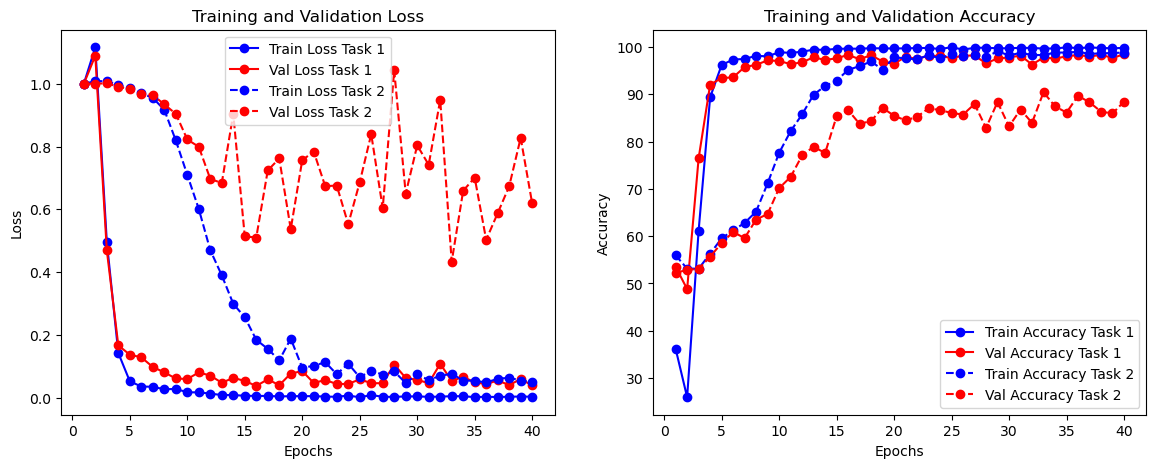

KeyboardInterrupt: 

In [ ]:
# Lists to store loss and accuracy metrics
train_losses, train_accuracies = [], []
train_losses2, train_accuracies2 = [], []
val_losses, val_accuracies = [], []
val_losses2, val_accuracies2 = [], []
val_losses3, val_accuracies3 = [], []

initial_loss1 = None
initial_loss2 = None

epochs = 300

# Training loop
for epoch in range(epochs):
    external_iter = iter(trainloader)
    train_losses_batch, train_accuracies_batch = [], []
    train_losses2_batch, train_accuracies2_batch = [], []

    for i, data in enumerate(externalloader):
        # Internal data (task 1)
        try:
            inputs, labels = next(external_iter)
        except StopIteration:
            external_iter = iter(trainloader)
            inputs, labels = next(external_iter)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs1, outputs2 = model(inputs)
        loss1 = criterion1(outputs1, labels)

        # External data (task 2)
        external_inputs, _ = data
        external_labels = torch.zeros(len(external_inputs), 1).to(device)
        external_inputs = external_inputs.to(device)
        _, external_outputs2 = model(external_inputs)
        external_loss = criterion2(external_outputs2, external_labels)

        labels2 = torch.ones(len(inputs), 1).to(device)
        loss2 = criterion2(outputs2, labels2)

        # Save initial loss values for normalization
        if initial_loss1 is None:
            initial_loss1 = loss1.item()
        if initial_loss2 is None:
            initial_loss2 = (external_loss + loss2).item()

        # Normalize losses and combine
        normalized_loss1 = loss1 / initial_loss1
        normalized_loss2 = (external_loss + loss2) / initial_loss2
        total_loss = normalized_loss1 + normalized_loss2
        total_loss.backward()
        optimizer.step()

        # Accuracy for task 1
        _, predicted = torch.max(outputs1.data, 1)
        accuracy1 = (predicted == labels).float().mean().item() * 100
        train_losses_batch.append(loss1.item())
        train_accuracies_batch.append(accuracy1)

        # Accuracy for task 2
        outputstask2 = torch.cat((external_outputs2, outputs2), dim=0)
        labelstask2 = torch.cat((external_labels, labels2), dim=0)
        predicted2 = torch.round(outputstask2)
        accuracy2 = (predicted2 == labelstask2).float().mean().item() * 100
        losstask2 = external_loss + loss2

        train_losses2_batch.append(losstask2.item())
        train_accuracies2_batch.append(accuracy2)
        train_losses2.append(losstask2.item())
        train_accuracies2.append(accuracy2)

    # End of epoch stats
    train_losses.append(np.mean(train_losses_batch))
    train_accuracies.append(np.mean(train_accuracies_batch))

    val_loss, val_accuracy = evaluate_model()
    val_accuracy2, val_loss2 = evaluate_model2(model, trainloader, valloader, device)
    val_accuracy3, val_loss3 = evaluate_model2(model, trainloader, externalloader, device)

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_accuracies2.append(val_accuracy2 * 100)
    val_accuracies3.append(val_accuracy3 * 100)
    val_losses2.append(val_loss2)
    val_losses3.append(val_loss3)

    # Plot metrics
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, 
                 val_losses3, val_losses2, val_accuracies3, val_accuracies2)

print('Finished Training')

c:\Users\Ivan\anaconda3\envs\MembershipInferenceActive_1\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Ivan\anaconda3\envs\MembershipInferenceActive_1\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


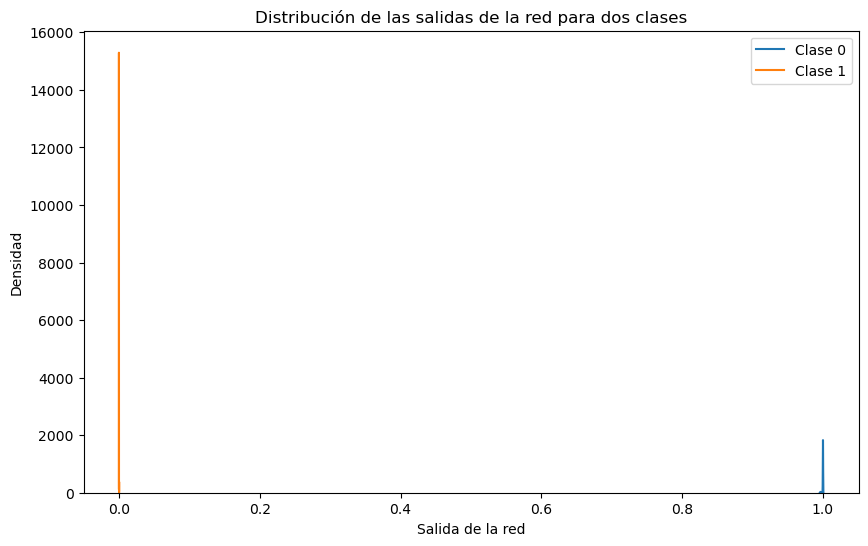

In [ ]:
# Convert tensors to numpy arrays if they are PyTorch tensors
if isinstance(outputs2, torch.Tensor):
    outputs_class_0 = outputs2.cpu().detach().numpy()
if isinstance(external_outputs2, torch.Tensor):
    outputs_class_1 = external_outputs2.cpu().detach().numpy()

# outputs_class_0 = np.random.rand(6400,1)
# outputs_class_1 = np.random.rand(6400,1)

outputs_class_0_flat = outputs_class_0.flatten()
outputs_class_1_flat = outputs_class_1.flatten()

# Plot the output distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(outputs_class_0_flat, label='Class 0')
sns.kdeplot(outputs_class_1_flat, label='Class 1')

plt.title('Output distribution for both classes')
plt.xlabel('Network output')
plt.ylabel('Density')
plt.legend()
plt.show()
